In [55]:
import torch
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [56]:
content_path = './content/content_image.jpg'
style_path = './style/style_pic.jpg'

def load_image(image_path):
    try:
        image = Image.open(image_path)
        if image is None:
            raise ValueError(f'Can not load image, please check path:{image_path}')
    except Exception as e:
        raise ValueError(f"Can not read image:{e}")

    return image

content_image = load_image(content_path)
style_image = load_image(style_path)


In [57]:
# 对输入图形进行预处理
def preprocess(img):
    Preprocess = transforms.Compose([
        transforms.Resize((256,256)), # 改变图形大小
        transforms.ToTensor(),  # 调整为Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 标准化
    ])

    return Preprocess(img).unsqueeze(0) # 便于批量处理,在dim0上扩展维度

content_image = preprocess(content_image)
style_image = preprocess(style_image)
print(content_image)
print(style_image)

tensor([[[[ 0.1939,  0.1254,  0.0569,  ..., -0.2513, -0.1657, -0.1143],
          [ 0.1426,  0.0912,  0.0227,  ..., -0.3369, -0.2684, -0.2171],
          [ 0.0912,  0.0398, -0.0116,  ..., -0.4397, -0.3712, -0.3198],
          ...,
          [ 0.1083, -0.0458, -0.0629,  ...,  0.2796,  0.2624,  0.3823],
          [ 0.1083, -0.0458, -0.0458,  ...,  0.2967,  0.2624,  0.3138],
          [ 0.0569,  0.0056,  0.0056,  ...,  0.3481,  0.2967,  0.3652]],

         [[ 0.9055,  0.8354,  0.7479,  ...,  0.2927,  0.3627,  0.4328],
          [ 0.8529,  0.7829,  0.7129,  ...,  0.2227,  0.2927,  0.3627],
          [ 0.8004,  0.7479,  0.6779,  ...,  0.1176,  0.2052,  0.2577],
          ...,
          [ 0.1527, -0.0049, -0.0224,  ...,  0.3627,  0.3277,  0.4678],
          [ 0.1527, -0.0049, -0.0049,  ...,  0.3978,  0.3627,  0.4153],
          [ 0.0651,  0.0126,  0.0126,  ...,  0.4503,  0.3978,  0.4678]],

         [[ 2.0300,  1.9951,  1.9777,  ...,  1.4548,  1.5071,  1.5245],
          [ 1.9951,  1.9603,  

In [58]:
class VGGFeatures(torch.nn.Module):
    def __init__(self):
        super(VGGFeatures,self).__init__()
        self.vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:21].eval()
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for layer in self.vgg:
            x = layer(x)
            if isinstance(layer, torch.nn.ReLU):
                features.append(x)
        return features
        

In [59]:
# 提取特征
def get_features(image, model):
    layers = {
        0 :'conv1', 
        2 :'conv2',
        5 :'conv3',
        7 :'conv4', 
        10:'conv5',
        12:'conv6',
        14:'conv7',
        16:'conv8',
        19:'conv9'

    }
    features = {}
    x = image

    for name, layer in model._modules.items():
        for i in range(len(layer)):
            x = layer[i](x)
            if i in layers.keys():
                features[layers[i]] = x

    return features

# 计算内容损失
def content_loss(content_weight, content_features, target_features):
    return content_weight * torch.mean((target_features - content_features) ** 2)

# 计算风格损失
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [60]:
def style_loss(style_weight, style_grams, target_features):
    loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_loss = style_weight * torch.mean((target_gram - style_gram) ** 2)
        loss += layer_loss
    return loss

Step 0, Content Loss:0.0, Style Loss:282251624448.0
Total loss:282251624448.0, percentage:100.0%
Step 100, Content Loss:103449.1328125, Style Loss:40736452608.0
Total loss:40736555008.0, percentage:14.432708740234375%
Step 200, Content Loss:130098.140625, Style Loss:18811344896.0
Total loss:18811475968.0, percentage:6.664789199829102%
Step 300, Content Loss:144881.265625, Style Loss:10962880512.0
Total loss:10963024896.0, percentage:3.884131669998169%
Step 400, Content Loss:155994.984375, Style Loss:7206104576.0
Total loss:7206260736.0, percentage:2.553133487701416%
Step 500, Content Loss:164479.84375, Style Loss:5209866240.0
Total loss:5210030592.0, percentage:1.8458815813064575%
Step 600, Content Loss:170920.046875, Style Loss:4035467520.0
Total loss:4035638528.0, percentage:1.4298017024993896%
Step 700, Content Loss:176340.84375, Style Loss:3285563904.0
Total loss:3285740288.0, percentage:1.164117455482483%
Step 800, Content Loss:180983.828125, Style Loss:2773867520.0
Total loss:277

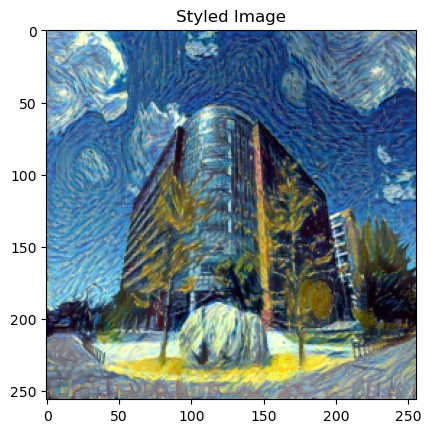

In [63]:
# 初始化模型和特征
vgg = VGGFeatures()
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# 初始化目标图像
target_image = content_image.clone().requires_grad_(True)

# 优化器
optimizer = optim.Adam([target_image], lr=0.003)

# 训练循环
num_steps = 2000
content_weight = 1e4
style_weight = 1e2
init_loss = 0

for step in range(num_steps):
    target_features = get_features(target_image, vgg)
    c_loss = content_loss(content_weight, content_features['conv9'], target_features['conv9'])
    s_loss = style_loss(style_weight, style_grams, target_features)
    total_loss = c_loss + s_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step == 0:
        init_loss = total_loss
    if step % 100 == 0:
        print(f"Step {step}, Content Loss:{c_loss.item()}, Style Loss:{s_loss.item()}")
        print(f"Total loss:{total_loss}, percentage:{(100*total_loss/init_loss)}%")

# 显示结果
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

imshow(target_image, title='Styled Image')